# MCMC for optimizing the 2-layer multiple output Neural Network

Now with corrected obs

Note this code follows variable output in `NN_opt_plot.ipynb`

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

In [2]:
var = ["GPP", "LHF"]
nvar = len(var)

In [3]:
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kd

In [4]:
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

In [5]:
NN_models = [load_model("../emulators/NN_"+v+"_finalize_multi-dim.h5", 
    custom_objects={'mean_sq_err' :mean_sq_err}) for v in var]

W1207 13:59:17.563297 47945263267264 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1207 13:59:17.582949 47945263267264 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1207 13:59:17.633548 47945263267264 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1207 13:59:17.634233 47945263267264 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto is d

In [6]:
# variance recorded in NN develop and test spreadsheet, taken from SVD.ipynb
var_modes = [[0.83406484, 0.1348919, 0.01192334],[0.7701996, 0.12915632, 0.05642754]]

In [7]:
Fobs = [np.load("../obs/obs_"+v+"_SVD_3modes.npy") for v in var]

In [8]:
obs_sd = [np.load("../obs/obs_"+v+"_SVD_3modes_allyrs_sd.npy") for v in var]

Cost function for MCMC

In [9]:
def normerr_MCMC(x):
    xt = x.reshape(1,-1)
    NN_preds = [NN_models[i].predict(xt) for i,v in enumerate(var)]
    terms = [np.sum(var_modes[i]*((NN_preds[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
    L = -(np.sum(terms)) # unweighted sum (as in, no scaling factor for LHF)
    return L

Define the prior

In [10]:
def lnprior(x):
    #if x.any() >= 0 and x.any() <= 1:
    #if all(x > 0) and all(x < 1):
    if np.all(x > 0) and np.all(x < 1):
        return 0.0
    return -np.inf

Define full log prob function

In [11]:
def lnprob(x):
    lp = lnprior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + normerr_MCMC(x)

Number of walkers, number of dimensions = number of parameters

In [12]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

In [13]:
# Note that number of walkers is correlated with runtime
nwalkers = 100
ndim = npar

Initialize walkers (random initial states)\
TO DO: try different initial states here

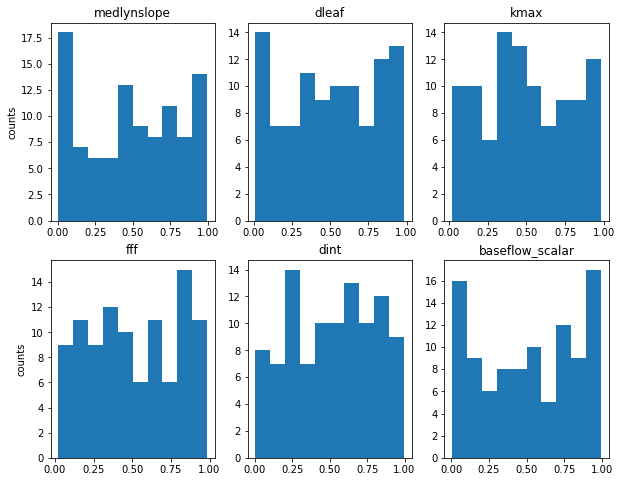

In [14]:
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

# sanity check initial values
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(10, 8))
labels = in_vars
axes = axes.flatten()
for p in range(ndim):
    ax = axes[p]
    ax.hist([p0[i][p] for i in range(nwalkers)])
    ax.set_title(labels[p])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");

Initialize walkers (normal distribution with specified mean and variance)

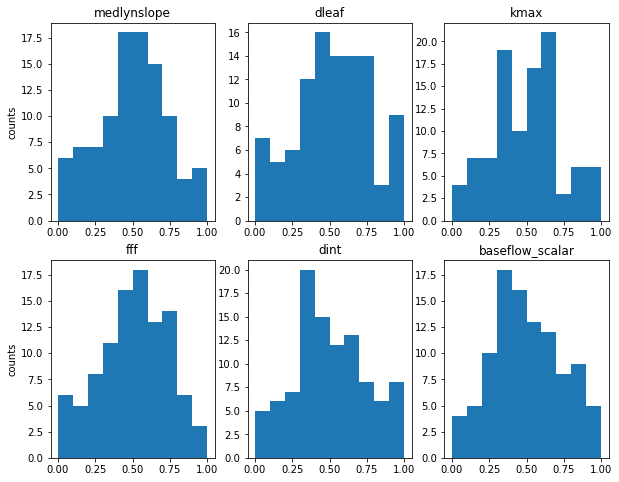

In [24]:
mu = 0.5 # mean
sigma = 0.25 # variance
p0 = [mu + sigma*np.random.randn(ndim) for i in range(nwalkers)]

# clip p0 to force [0,1] bounds
p0 = np.clip(p0, 0, 1)

# sanity check initial values
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(10, 8))
labels = in_vars
axes = axes.flatten()
for p in range(ndim):
    ax = axes[p]
    ax.hist([p0[i][p] for i in range(nwalkers)])
    ax.set_title(labels[p])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");

Intialize walkers in a tight ball around single-point optimization values

In [16]:
# see NN_opt_plot.ipynb for these results
opt_params_preserved = [5.35314627e-01, 9.98124407e-01, 3.08100513e-01, 1.05168812e-04,
       9.98661100e-01, 2.25861839e-04]

In [17]:
initial = opt_params_preserved
tol = 10**-4 # vary this parameter
# note: tol=0 corresponds to initializing with exact results; doesn't appear to move beyond these values in testing)
p0 = [np.array(initial) + tol * np.random.randn(ndim) for i in range(nwalkers)]
# note: np.random.rand produces random numbers from a uniform distribution over [0,1], whereas np.random.randn produces random numbers from standard normal
# here mean = optimization results, variance = tol
#print(np.var(p0[0])) # variance across p0

clip p0 to force [0,1] bounds

In [18]:
p0 = np.clip(p0, 0, 1)

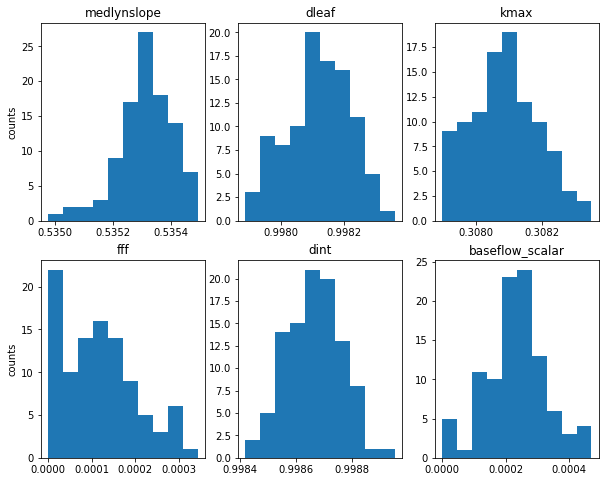

In [19]:
# sanity check initial values
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(10, 8))
labels = in_vars
axes = axes.flatten()
for p in range(ndim):
    ax = axes[p]
    ax.hist([p0[i][p] for i in range(nwalkers)])
    ax.set_title(labels[p])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");

Set up sampler

In [27]:
# Serial
# need to re-run this cell every time I change epochs (or sampler will append new values)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run Sampler

In [28]:
epochs = 1*10**4
result = sampler.run_mcmc(p0, epochs, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [07:22<00:00, 22.60it/s]


Mean acceptance fraction

In [29]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.338


Plot progression

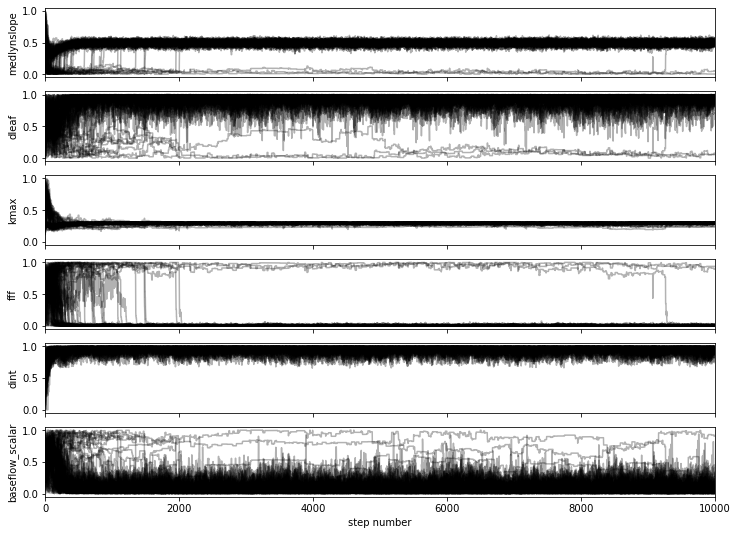

In [31]:
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples_all = sampler.get_chain()
labels = in_vars
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel("step number");
#plt.savefig("MCMC_samplerchain_1e4epochs_randnorm.png")

Plot log probability

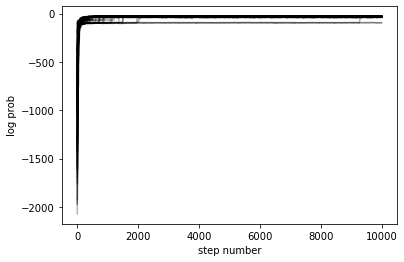

In [32]:
probs_all = sampler.get_log_prob()
#print(probs_all.shape)
plt.plot(probs_all, "k", alpha=0.3) # can't figure out the best way to plot this; too large to exponentiate
plt.xlabel("step number")
plt.ylabel("log prob");

Average log probability for last position of all walkers

In [33]:
print(np.mean(probs_all[epochs-1,:]))

-32.55735666099274


Get estimate of autocorrelation time - helps determine length of chain (number of epochs)

In [34]:
tau = sampler.get_autocorr_time()
print(tau) # do I need a longer chain? emcee will produce generalized estimates/guidance (i.e., run for epochs=50*tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [304.32217975 326.36961782 154.33485272 334.27080012 144.20721257
 303.02416298]

Plot autocorrelation using different estimates - first define some functions

In [35]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

# automated windowing following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

Iterate over all dimensions and plot

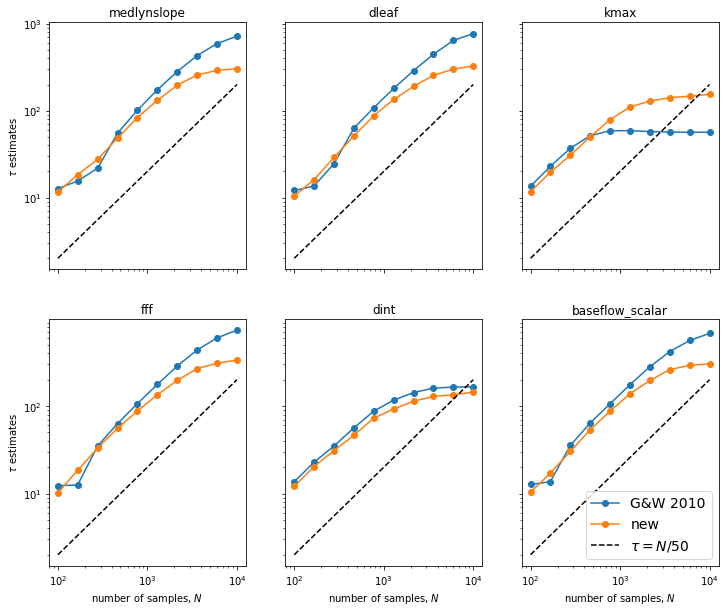

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize=(12, 10))
labels = in_vars
axes = axes.flatten()
for p in range(ndim):
    chain = samples_all[:,:,p].T
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
    gw2010 = np.empty(len(N))
    new = np.empty(len(N))

    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])

    # need to run for a long enough chain to get a meaningful figure
    ax = axes[p]
    ax.loglog(N, gw2010, "o-", label="G&W 2010")
    ax.loglog(N, new, "o-", label="new")
    #ylim = plt.gca().get_ylim()
    ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    #ax.set_ylim(ylim)
    ax.set_title(labels[p])
    
axes[3].set_xlabel("number of samples, $N$")
axes[4].set_xlabel("number of samples, $N$")
axes[5].set_xlabel("number of samples, $N$")
axes[0].set_ylabel(r"$\tau$ estimates")
axes[3].set_ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);
#plt.savefig("MCMC_autocorr_2e4epochs_1e-4tol.pdf")

Plot distributions for final position

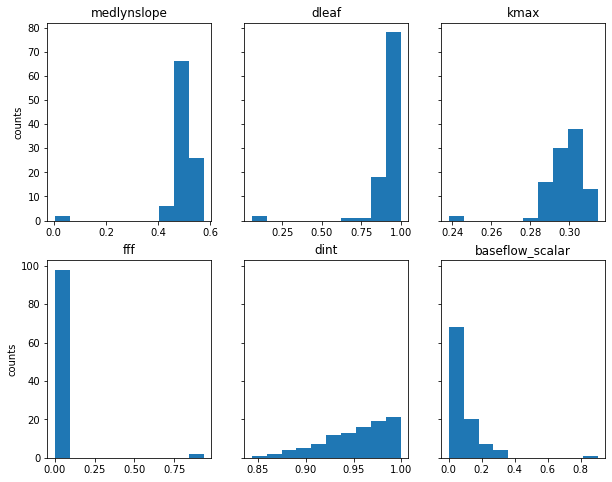

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey='row', figsize=(10, 8))
labels = in_vars
axes = axes.flatten()
for i in range(ndim):
    ax = axes[i]
    #ax.hist(sampler.chain[:,epochs-1,i], color="k", histtype="step")
    ax.hist(sampler.chain[:,epochs-1,i])
    ax.set_title(labels[i])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");

#plt.savefig("MCMC_lastsample_1e4epochs_randnorm.pdf")

Corner plot

W1207 14:28:01.633479 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:02.377103 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:02.481243 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:02.608452 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:02.710274 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:02.805666 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:02.937408 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:03.039764 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:03.138303 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:03.235621 47945263267264 corner.py:542] Too few points to create valid contours
W1207 14:28:03.592513 47945263267264 corner.py:542] Too few points to create val

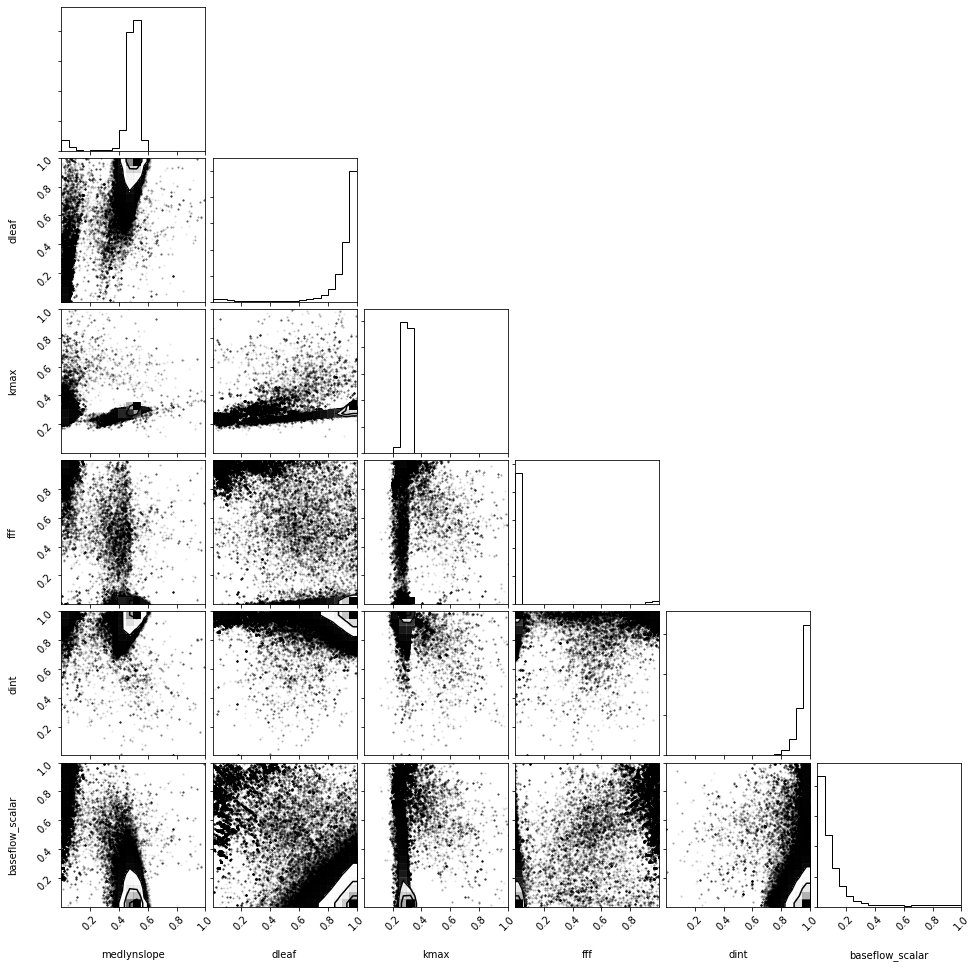

In [38]:
# discard the initial N steps
#flat_samples = sampler.get_chain(discard=10000, flat=True)
# no discard (faster convergence based on initialization)
flat_samples = sampler.get_chain(flat=True)
import corner
fig = corner.corner(flat_samples, labels=in_vars)
#plt.savefig("MCMC_corner_2e4epochs_1e-4tol.pdf")

In [39]:
# final values for all walkers
last_sample = sampler.chain[:,epochs-1,:]
print(last_sample.shape)
print(np.mean(last_sample, axis=0)) # average (over walkers) last position of each parameter
#np.save("posterior_dists/MCMC_lastsample_1e4epochs_randnorm", last_sample)

(100, 6)
[0.49351874 0.92531065 0.29794413 0.02354321 0.95216414 0.08372557]
